<h1 class="font-effect-3d" style="font-family:Sancreek; color:#39d4be;">Code Modules, Styling, and Links</h1>

#### [GitHub Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP2) & [Colaboratory Version](https://colab.research.google.com/drive/1Z9Fz0OOi6bpWvH-H2OhExC9CkGPWBYZz)

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Sancreek|Roboto&effect=3d');
span {font-family:Roboto; color:black; text-shadow:4px 4px 4px #aaa;}  
a,h4,div.output_area pre{font-family:Roboto; font-size:120%; color:#39d4be;}      
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd 
import os,h5py,pylab as pl
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import misc
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.applications.nasnet import NASNetLarge,NASNetMobile
from keras.applications.nasnet import preprocess_input as nnpi
print(os.listdir("../input"))

Using TensorFlow backend.


['classification-of-handwritten-letters', 'keras-applications-weights']


<h1 class="font-effect-3d" style="font-family:Sancreek; color:#39d4be;">Preprocess the Data</h1>

In [3]:
fpath="../input/classification-of-handwritten-letters/"
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
f=h5py.File(fpath+'LetterColorImages_123.h5','r')
keys=list(f.keys()); n=2700
backgrounds=np.array(f[keys[0]])[:n]
images=np.array(f[keys[1]])[:n]/255
labels=np.array(f[keys[2]])[:n]
[keys,
 [backgrounds.shape,images.shape,labels.shape]]

[['backgrounds', 'images', 'labels'], [(2700,), (2700, 32, 32, 3), (2700,)]]

Label:  в


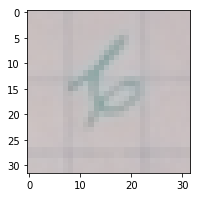

In [4]:
ri=np.random.randint(n)
print('Label: ', letters[labels[ri]-1])
pl.figure(figsize=(3,3))
pl.imshow(images[ri]); pl.show()

In [5]:
print(set(labels))
print("{а, б, в, г, д ,е, ё, ж, з, и, й, к, л, м, н, о, п, "+\
      "р, с, т, у, ф, х, ц, ч, ш, щ, ъ, ы, ь, э, ю, я}")

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
{а, б, в, г, д ,е, ё, ж, з, и, й, к, л, м, н, о, п, р, с, т, у, ф, х, ц, ч, ш, щ, ъ, ы, ь, э, ю, я}


In [6]:
# one-hot encoding the labels, started from the zero label
cat_labels=to_categorical(np.array(labels-1),33)
cat_labels.shape

(2700, 33)

In [7]:
# splitting the data
x_train,x_test,y_train,y_test=\
train_test_split(images,cat_labels,test_size=.2,random_state=1)
m=int(len(x_test)/2)
x_valid,y_valid=x_test[:m],y_test[:m]
x_test,y_test=x_test[m:],y_test[m:]
print([x_train.shape,x_valid.shape,x_test.shape,
       y_train.shape,y_valid.shape,y_test.shape])

[(2160, 32, 32, 3), (270, 32, 32, 3), (270, 32, 32, 3), (2160, 33), (270, 33), (270, 33)]


In [8]:
del images,labels,cat_labels,backgrounds

<h1 class="font-effect-3d" style="font-family:Sancreek; color:#39d4be;">Classification Models</h1>
#### NASnetLarge

In [9]:
# creating bottleneck features
x_train=np.array([misc.imresize(x_train[i],(331,331,3)) 
                  for i in range(0,len(x_train))]).astype('float32')
x_valid=np.array([misc.imresize(x_valid[i],(331,331,3)) 
                  for i in range(0,len(x_valid))]).astype('float32')
x_test=np.array([misc.imresize(x_test[i],(331,331,3)) 
                 for i in range(0,len(x_test))]).astype('float32')
x_train=nnpi(x_train)
x_valid=nnpi(x_valid)
x_test=nnpi(x_test)
fn="../input/keras-applications-weights/nasnet_large_no_top.h5"
nasnet_base_model=NASNetLarge(weights=fn,include_top=False)
x_train=nasnet_base_model.predict(x_train)
x_valid=nasnet_base_model.predict(x_valid)
x_test=nasnet_base_model.predict(x_test)

In [10]:
def nasnet_model():
    model = Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=x_train.shape[1:]))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))    
    model.add(Dense(33,activation='softmax'))     
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
nasnet_model=nasnet_model()

In [11]:
fw='weights.best.nasnet.hdf5'
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=nasnet_model.fit(x_train,y_train,
                         validation_data=(x_valid,y_valid),
                         epochs=100,batch_size=128,verbose=2,
                         callbacks=[checkpointer,lr_reduction,estopping]);

Train on 2160 samples, validate on 270 samples
Epoch 1/100
 - 13s - loss: 3.1884 - acc: 0.1542 - val_loss: 2.4896 - val_acc: 0.2741

Epoch 00001: val_loss improved from inf to 2.48956, saving model to weights.best.nasnet.hdf5
Epoch 2/100
 - 7s - loss: 2.5294 - acc: 0.2847 - val_loss: 2.4833 - val_acc: 0.3074

Epoch 00002: val_loss improved from 2.48956 to 2.48329, saving model to weights.best.nasnet.hdf5
Epoch 3/100
 - 7s - loss: 2.3555 - acc: 0.3218 - val_loss: 2.2034 - val_acc: 0.3667

Epoch 00003: val_loss improved from 2.48329 to 2.20338, saving model to weights.best.nasnet.hdf5
Epoch 4/100
 - 7s - loss: 2.1490 - acc: 0.3741 - val_loss: 2.1187 - val_acc: 0.3481

Epoch 00004: val_loss improved from 2.20338 to 2.11866, saving model to weights.best.nasnet.hdf5
Epoch 5/100
 - 7s - loss: 1.9972 - acc: 0.3991 - val_loss: 1.8842 - val_acc: 0.4556

Epoch 00005: val_loss improved from 2.11866 to 1.88416, saving model to weights.best.nasnet.hdf5
Epoch 6/100
 - 7s - loss: 1.8378 - acc: 0.4472

In [12]:
# loading the model with the best validation accuracy
nasnet_model.load_weights(fw)
# calculations of classification accuracy on the testing set
scores=nasnet_model.evaluate(x_test,y_test)
print("Accuracy: %.2f%%"%(scores[1]*100))
scores

270/270 [==============================] - 1s 3ms/step
Accuracy: 58.89%


[1.4213828289950337, 0.588888888447373]

In [13]:
del x_train,x_valid,x_test,y_train,y_valid,y_test

#### NASNetMobile

In [14]:
f=h5py.File(fpath+'LetterColorImages_123.h5','r')
keys=list(f.keys()); n=4000
images=np.array(f[keys[1]])[:n]/255
labels=np.array(f[keys[2]])[:n]
cat_labels=to_categorical(np.array(labels-1),33)
x_train,x_test,y_train,y_test=\
train_test_split(images,cat_labels,test_size=.2,random_state=1)
m=int(len(x_test)/2)
x_valid,y_valid=x_test[:m],y_test[:m]
x_test,y_test=x_test[m:],y_test[m:]
print([x_train.shape,x_valid.shape,x_test.shape,
       y_train.shape,y_valid.shape,y_test.shape])
del images,labels,cat_labels

[(3200, 32, 32, 3), (400, 32, 32, 3), (400, 32, 32, 3), (3200, 33), (400, 33), (400, 33)]


In [15]:
# creating bottleneck features
x_train=np.array([misc.imresize(x_train[i],(224,224,3)) \
                  for i in range(0,len(x_train))]).astype('float32')
x_valid=np.array([misc.imresize(x_valid[i],(224,224,3)) \
                  for i in range(0,len(x_valid))]).astype('float32')
x_test=np.array([misc.imresize(x_test[i],(224,224,3)) \
                 for i in range(0,len(x_test))]).astype('float32')
x_train=nnpi(x_train)
x_valid=nnpi(x_valid)
x_test=nnpi(x_test)
fn="../input/keras-applications-weights/nasnet_mobile_no_top.h5"
nasnet_base_model=NASNetMobile(weights=fn,include_top=False)
x_train=nasnet_base_model.predict(x_train)
x_valid=nasnet_base_model.predict(x_valid)
x_test=nasnet_base_model.predict(x_test)

In [16]:
def nasnet_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=x_train.shape[1:]))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))    
    model.add(Dense(33,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
nasnet_model=nasnet_model()

In [17]:
fw='weights.best.nasnet.hdf5'
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=nasnet_model.fit(x_train,y_train,
                         validation_data=(x_valid,y_valid),
                         epochs=100,batch_size=128,verbose=2,
                         callbacks=[checkpointer,lr_reduction,estopping]);

Train on 3200 samples, validate on 400 samples
Epoch 1/100
 - 9s - loss: 3.2463 - acc: 0.1309 - val_loss: 2.3909 - val_acc: 0.3425

Epoch 00001: val_loss improved from inf to 2.39092, saving model to weights.best.nasnet.hdf5
Epoch 2/100
 - 1s - loss: 2.5041 - acc: 0.2812 - val_loss: 2.0442 - val_acc: 0.4350

Epoch 00002: val_loss improved from 2.39092 to 2.04417, saving model to weights.best.nasnet.hdf5
Epoch 3/100
 - 1s - loss: 2.2191 - acc: 0.3509 - val_loss: 1.8947 - val_acc: 0.4825

Epoch 00003: val_loss improved from 2.04417 to 1.89472, saving model to weights.best.nasnet.hdf5
Epoch 4/100
 - 1s - loss: 2.0262 - acc: 0.4150 - val_loss: 1.6566 - val_acc: 0.5150

Epoch 00004: val_loss improved from 1.89472 to 1.65657, saving model to weights.best.nasnet.hdf5
Epoch 5/100
 - 1s - loss: 1.8508 - acc: 0.4612 - val_loss: 1.6776 - val_acc: 0.5025

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 1s - loss: 1.7350 - acc: 0.4769 - val_loss: 1.5686 - val_acc: 0.5175

Epoch 00006: val_loss

In [18]:
# loading the model with the best validation accuracy
nasnet_model.load_weights(fw)
# calculations of classification accuracy on the testing set
scores=nasnet_model.evaluate(x_test,y_test)
print("Accuracy: %.2f%%"%(scores[1]*100))
scores

400/400 [==============================] - 0s 330us/step
Accuracy: 64.00%


[1.3512681794166566, 0.64]

In [19]:
del x_train,x_valid,x_test,y_train,y_valid,y_test